# Analysis of sound statistics
This notebook shows how to run an analysis of sound statistics.

In [16]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})
import IPython  # To play audio
import numpy as np
from jaratoolbox import soundanalysis
import importlib
importlib.reload(soundanalysis);

## Loading the sound
Let's say we want to analyze the following sound:

In [17]:
IPython.display.Audio('./soundsamples/bubbles.wav')

First, we create an instance of the sound analysis class, which can load a sound file:

In [18]:
sana = soundanalysis.SoundAnalysis(soundfile='./soundsamples/bubbles.wav')

This object gives access to the waveform (and a time vector):

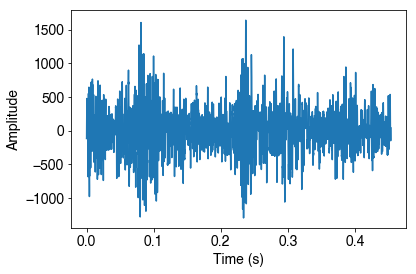

In [19]:
(tvec, wave) = sana.get_waveform(np.arange(10000)) # Get only the first 10k samples
plt.plot(tvec, wave);
plt.xlabel('Time (s)'); plt.ylabel('Amplitude');

We can check the spectrogram of this sound:

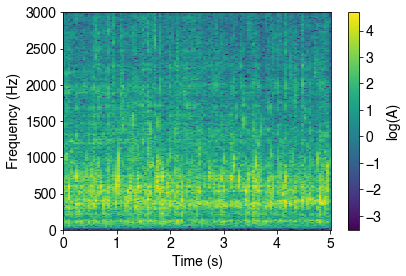

In [20]:
sgram = sana.plot_spectrogram()
plt.ylim([0,3000]);

## Creating a filterbank
To analyze the sound, we need to create a filterbank:

In [21]:
nBands = 6
endFilters = [20,8000] # Centers of lowest and highest filters (in Hz)
(nSamples, samplingRate, soundDuration) = sana.get_sound_parameters()
fbank = soundanalysis.FilterBank(nBands, endFilters, nSamples, samplingRate)

The filters will be equally spaced in [ERB space](https://en.wikipedia.org/wiki/Equivalent_rectangular_bandwidth). The object we created has a convenient method to plot the tranfer function of the filters. 

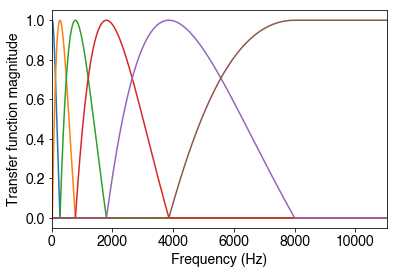

In [22]:
fbank.plot()

## Decomposition by frequency bands
To apply these filters, we need to have the the full transfer function (including negative frequencies), which we can get from the filterbank object:

In [23]:
transferFunction = fbank.get_transfer_function()
print(transferFunction.shape)

(6, 110250)


Let's apply the filterbank to our signal...

In [24]:
(tvec, bandsWaveforms) = sana.apply_filterbank(transferFunction)

...and estimate the envelope of each band (using the [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform)):

In [25]:
(tvecEnv, bandsEnvelopes) = sana.calculate_bands_envelopes()

To check our results, let's plot one band and its envelope:

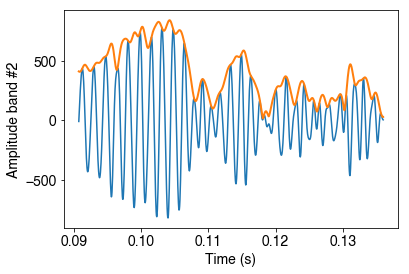

In [26]:
samplesToPlot = np.arange(2000,3000)
bandToPlot = 2
plt.plot(tvec[samplesToPlot],bandsWaveforms[bandToPlot,samplesToPlot])
plt.plot(tvecEnv[samplesToPlot],bandsEnvelopes[bandToPlot,samplesToPlot], lw=2)
plt.xlabel('Time (s)'); plt.ylabel('Amplitude band #{}'.format(bandToPlot));

## Signal compression
Let's take a look at the probability distribution of envelope values for the selected band:

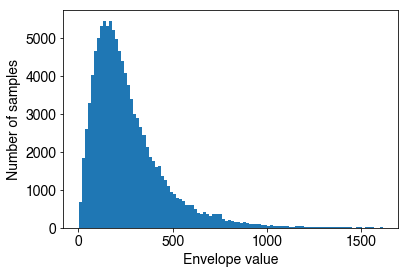

In [27]:
plt.hist(bandsEnvelopes[bandToPlot,:],100);
plt.xlabel('Envelope value'); plt.ylabel('Number of samples');

We see that the distribution has a long right tail. The cochlea evolved mechanisms to transform these values to a distribution with better dynamic range by applying **compression** (representing the low values with more bins than the high values).

Let's apply a power-law compression, $f(x)=x^k$ where $0<k<1$, and see how the transformed distribution looks like. The default exponent is $k=0.3$.

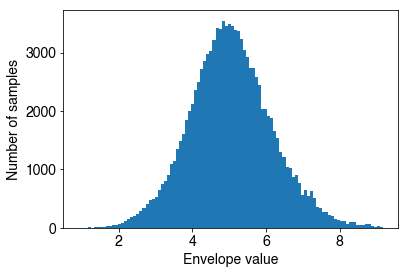

In [28]:
(tvecEnv, bandsEnvelopes) = sana.apply_compression()
plt.hist(bandsEnvelopes[bandToPlot,:],100);
plt.xlabel('Envelope value'); plt.ylabel('Number of samples');

## Bands' marginal statistics
We can then calculate the statistics for all the bands (actually of their compressed envelopes) and plot them:

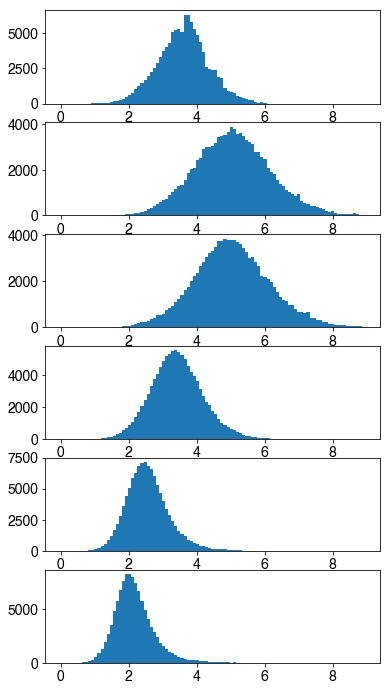

In [29]:
plt.figure(figsize=(6, 12))
sana.plot_bands_distributions()

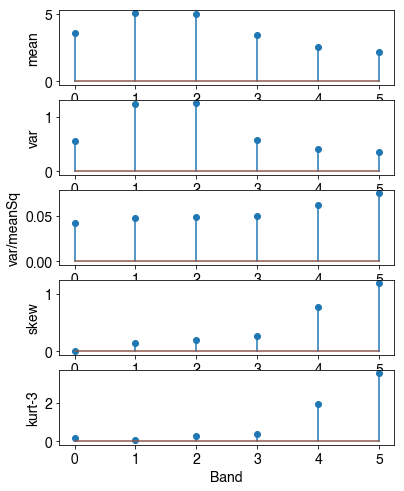

In [30]:
plt.figure(figsize=(6, 8))
bandStats = sana.calculate_bands_stats()
sana.plot_bands_stats()